In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from urllib.parse import urlparse
import tldextract
from collections import Counter
import math

warnings.filterwarnings(action='ignore')


In [5]:
train = pd.read_csv('../../data/train.csv')
test = pd.read_csv('../../data/test.csv')


In [6]:
# '[.]'을 '.'으로 복구
train['URL'] = train['URL'].str.replace(r'\[\.\]', '.', regex=True)
test['URL'] = test['URL'].str.replace(r'\[\.\]', '.', regex=True)



In [7]:
# 엔트로피 계산 함수 정의
def calculate_entropy(text):
    """
    주어진 문자열의 엔트로피를 계산합니다.

    Parameters:
    text (str): 엔트로피를 계산할 문자열

    Returns:
    float: 계산된 엔트로피 값
    """
    if not text:
        return 0

    # 각 문자의 빈도수 계산
    counter = Counter(text)

    # 문자열 길이
    length = len(text)

    # 각 문자의 확률 계산 후 엔트로피 계산
    entropy = 0
    for count in counter.values():
        probability = count / length
        entropy -= probability * math.log2(probability)

    return entropy



In [8]:
# URL 구조 세분화 전처리 과정 추가
def extract_url_features(df):
    # URL 기본 구성요소 추출: scheme, netloc, path, params, query, fragment
    parsed_urls = df['URL'].apply(urlparse)
    df['scheme'] = parsed_urls.apply(lambda x: x.scheme)
    df['netloc'] = parsed_urls.apply(lambda x: x.netloc)
    df['path'] = parsed_urls.apply(lambda x: x.path)
    df['params'] = parsed_urls.apply(lambda x: x.params)
    df['query'] = parsed_urls.apply(lambda x: x.query)
    df['fragment'] = parsed_urls.apply(lambda x: x.fragment)

    # tldextract를 이용하여 도메인 세분화: 서브도메인, 도메인, TLD 추출
    extracted = df['URL'].apply(tldextract.extract)
    df['subdomain_text'] = extracted.apply(lambda x: x.subdomain)
    df['domain_text'] = extracted.apply(lambda x: x.domain)
    df['suffix_text'] = extracted.apply(lambda x: x.suffix)

    # 추가 피처: 경로 내 세그먼트 개수, 쿼리 파라미터 개수
    df['path_segment_count'] = df['path'].apply(lambda x: len([seg for seg in x.split('/') if seg]))
    df['query_param_count'] = df['query'].apply(lambda x: len(x.split('&')) if x else 0)

    return df


# train, test 데이터에 URL 구조 세분화 적용
train = extract_url_features(train)
test = extract_url_features(test)


In [9]:
## 새로운 변수 생성
# URL 길이
train['length'] = train['URL'].str.len()
test['length'] = test['URL'].str.len()

# 서브도메인 개수 (기존 방식)
train['subdomain_count'] = train['URL'].str.split('.').apply(lambda x: len(x) - 2)
test['subdomain_count'] = test['URL'].str.split('.').apply(lambda x: len(x) - 2)

# 특수 문자('-', '_', '/') 개수
train['special_char_count'] = train['URL'].apply(lambda x: sum(1 for c in x if c in '-_/'))
test['special_char_count'] = test['URL'].apply(lambda x: sum(1 for c in x if c in '-_/'))

# 디지털 문자 관련
train['digit_count'] = train['URL'].str.count(r'\d')
test['digit_count'] = test['URL'].str.count(r'\d')
train['digit_ratio'] = train['digit_count'] / train['length']
test['digit_ratio'] = test['digit_count'] / test['length']

# 대문자 관련
train['uppercase_count'] = train['URL'].str.count(r'[A-Z]')
test['uppercase_count'] = test['URL'].str.count(r'[A-Z]')
train['uppercase_ratio'] = train['uppercase_count'] / train['length']
test['uppercase_ratio'] = test['uppercase_count'] / test['length']

# 추가 특수문자
train['abnormal_chars'] = train['URL'].str.count(r'[^a-zA-Z0-9\-\./_]')
test['abnormal_chars'] = test['URL'].str.count(r'[^a-zA-Z0-9\-\./_]')
train['dots_count'] = train['URL'].str.count(r'\.')
test['dots_count'] = test['URL'].str.count(r'\.')

# URL 구조 관련 기존 피처
train['path_length'] = train['URL'].apply(lambda x: len(x.split('/')[-1]) if '/' in x else 0)
test['path_length'] = test['URL'].apply(lambda x: len(x.split('/')[-1]) if '/' in x else 0)

train['query_count'] = train['URL'].str.count(r'\?')
test['query_count'] = test['URL'].str.count(r'\?')

train['and_count'] = train['URL'].str.count(r'\&')
test['and_count'] = test['URL'].str.count(r'\&')


In [10]:
# 엔트로피 특성 추가
# 전체 URL의 엔트로피
train['url_entropy'] = train['URL'].apply(calculate_entropy)
test['url_entropy'] = test['URL'].apply(calculate_entropy)

# 도메인 부분의 엔트로피
train['domain_entropy'] = train['netloc'].apply(calculate_entropy)
test['domain_entropy'] = test['netloc'].apply(calculate_entropy)

# 경로 부분의 엔트로피
train['path_entropy'] = train['path'].apply(calculate_entropy)
test['path_entropy'] = test['path'].apply(calculate_entropy)

# 쿼리 부분의 엔트로피
train['query_entropy'] = train['query'].apply(calculate_entropy)
test['query_entropy'] = test['query'].apply(calculate_entropy)

# 서브도메인 부분의 엔트로피
train['subdomain_entropy'] = train['subdomain_text'].apply(calculate_entropy)
test['subdomain_entropy'] = test['subdomain_text'].apply(calculate_entropy)

# TLD 부분의 엔트로피
train['tld_entropy'] = train['suffix_text'].apply(calculate_entropy)
test['tld_entropy'] = test['suffix_text'].apply(calculate_entropy)

# 최상위 도메인의 엔트로피
train['main_domain_entropy'] = train['domain_text'].apply(calculate_entropy)
test['main_domain_entropy'] = test['domain_text'].apply(calculate_entropy)


In [11]:
# 상관계수 계산 (새로 추가된 엔트로피 특성 포함)
feature_cols = ['length', 'subdomain_count', 'special_char_count',
                'digit_count', 'digit_ratio', 'uppercase_count', 'uppercase_ratio',
                'abnormal_chars', 'dots_count', 'path_length', 'query_count', 'and_count',
                'url_entropy', 'domain_entropy', 'path_entropy', 'query_entropy',
                'subdomain_entropy', 'tld_entropy', 'main_domain_entropy']

correlation_matrix = train[feature_cols + ['label']].corr()

# label과의 상관관계 확인
label_corr = correlation_matrix['label'].abs().sort_values(ascending=False)
print("\n특성과 label의 상관관계 (절대값 기준 내림차순):")
print(label_corr)

# 상관계수 0.3 이상인 특성 선택
selected_features = label_corr[label_corr >= 0.3].index.tolist()
selected_features.remove('label')  # label 제외
print("\n선택된 특성:", selected_features)

# 최종 데이터셋 생성
final_train = train[['ID', 'URL', 'label'] + selected_features]
final_test = test[['ID', 'URL'] + selected_features]

print("\n최종 학습 데이터 shape:", final_train.shape)
print("최종 테스트 데이터 shape:", final_test.shape)



특성과 label의 상관관계 (절대값 기준 내림차순):
label                  1.000000
url_entropy            0.504389
path_entropy           0.490501
subdomain_entropy      0.414697
digit_ratio            0.363634
special_char_count     0.356997
dots_count             0.350023
subdomain_count        0.350023
length                 0.326656
digit_count            0.251722
uppercase_ratio        0.241069
path_length            0.230710
query_entropy          0.227274
query_count            0.216031
and_count              0.119879
uppercase_count        0.113967
tld_entropy            0.065273
abnormal_chars         0.040008
main_domain_entropy    0.035250
domain_entropy         0.002393
Name: label, dtype: float64

선택된 특성: ['url_entropy', 'path_entropy', 'subdomain_entropy', 'digit_ratio', 'special_char_count', 'dots_count', 'subdomain_count', 'length']

최종 학습 데이터 shape: (6995056, 11)
최종 테스트 데이터 shape: (1747689, 10)


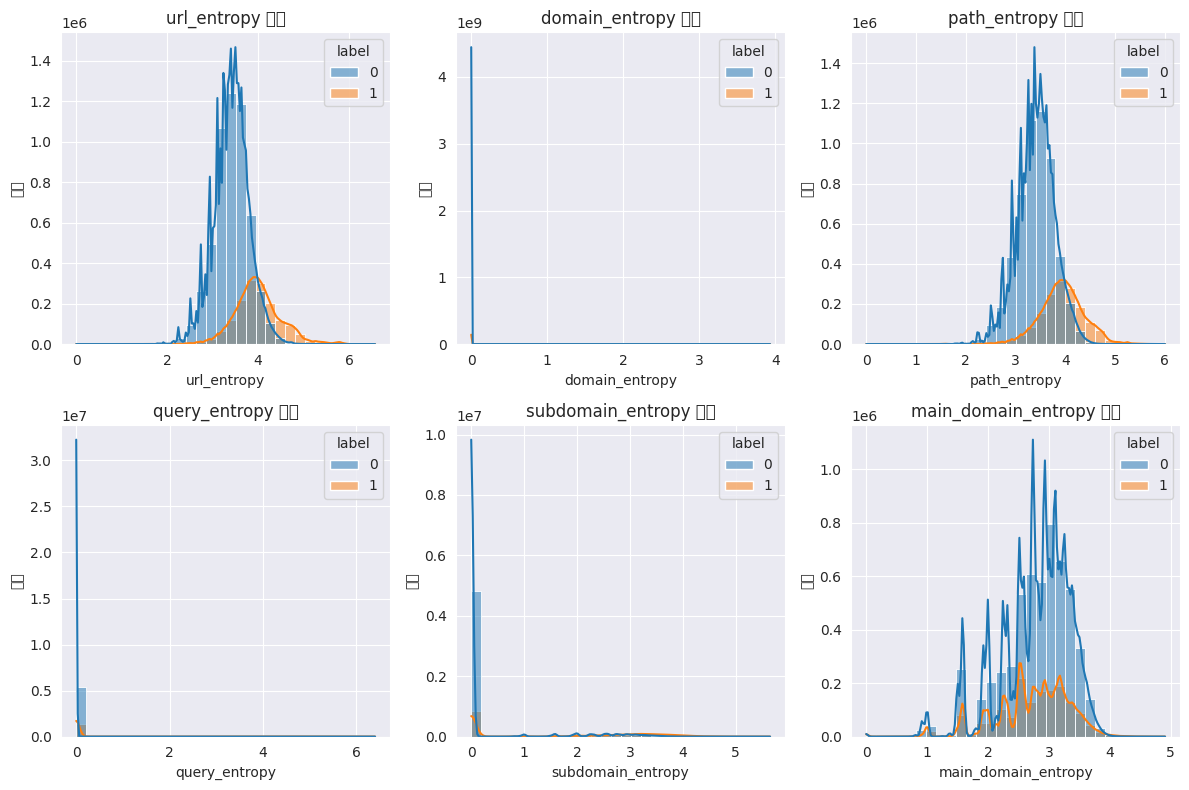

In [13]:
# 엔트로피 특성의 분포 시각화
plt.figure(figsize=(12, 8))

for i, feature in enumerate(['url_entropy', 'domain_entropy', 'path_entropy',
                             'query_entropy', 'subdomain_entropy', 'main_domain_entropy']):
    plt.subplot(2, 3, i + 1)
    sns.histplot(data=train, x=feature, hue='label', kde=True, bins=30)
    plt.title(f'{feature} 분포')
    plt.xlabel(feature)
    plt.ylabel('빈도')

plt.tight_layout()
plt.savefig('../../data/entropy_features_distribution.png')
plt.show()


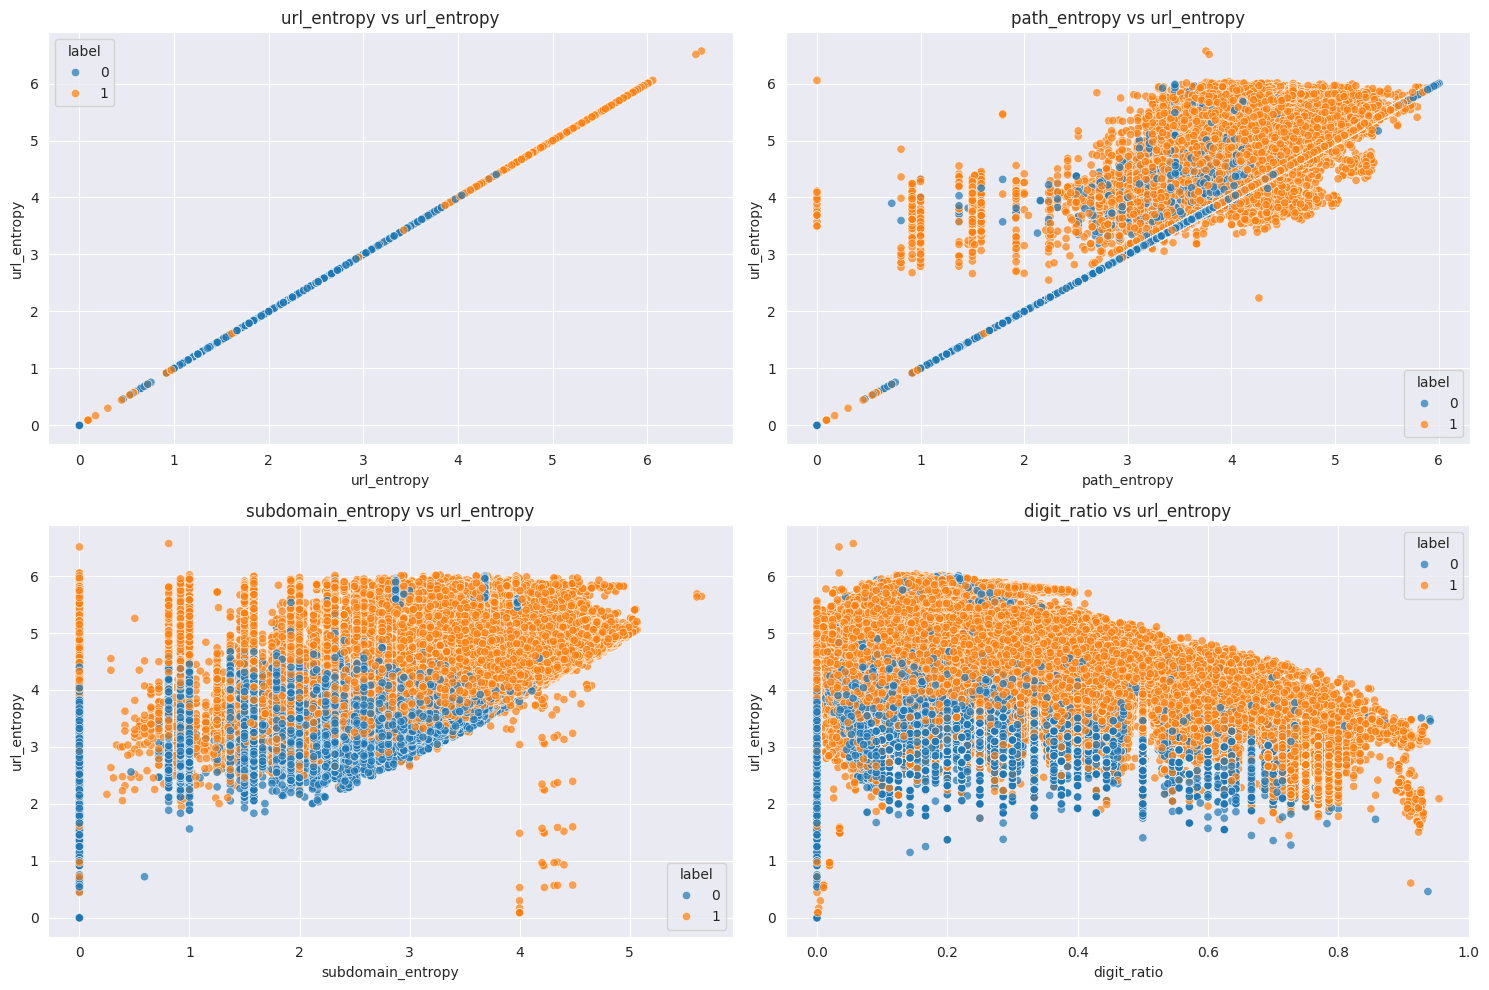

In [14]:
# 엔트로피 특성과 다른 주요 특성 간의 산점도
plt.figure(figsize=(15, 10))

# 상위 4개 특성과 url_entropy의 관계
top_features = label_corr.iloc[1:5].index.tolist()  # label 제외한 상위 4개 특성

for i, feature in enumerate(top_features):
    plt.subplot(2, 2, i + 1)
    sns.scatterplot(data=train, x=feature, y='url_entropy', hue='label', alpha=0.7)
    plt.title(f'{feature} vs url_entropy')

plt.tight_layout()
plt.savefig('../../data/entropy_correlation_scatter.png')
plt.show()


In [15]:
final_train.to_csv('../../data/preprocessed_data/final_train_ver2.csv', index=False)
final_test.to_csv('../../data/preprocessed_data/final_test_ver2.csv', index=False)